# In this notebook, LSTM Univariate models will be explored

In [7]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

## LSTM

#### Reload the data

The plan:

First run only price data to do a univariate LSTM ... DONE
Check results for all data including 2020 ... Poor Results

Check results for 2019 data only ... DONE, good results
Compare predictions with known 2020 data ... DONE dood results

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

In [8]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return timestamp

In [9]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [10]:
# # chop out 2020 data
# df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [11]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Kgs')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

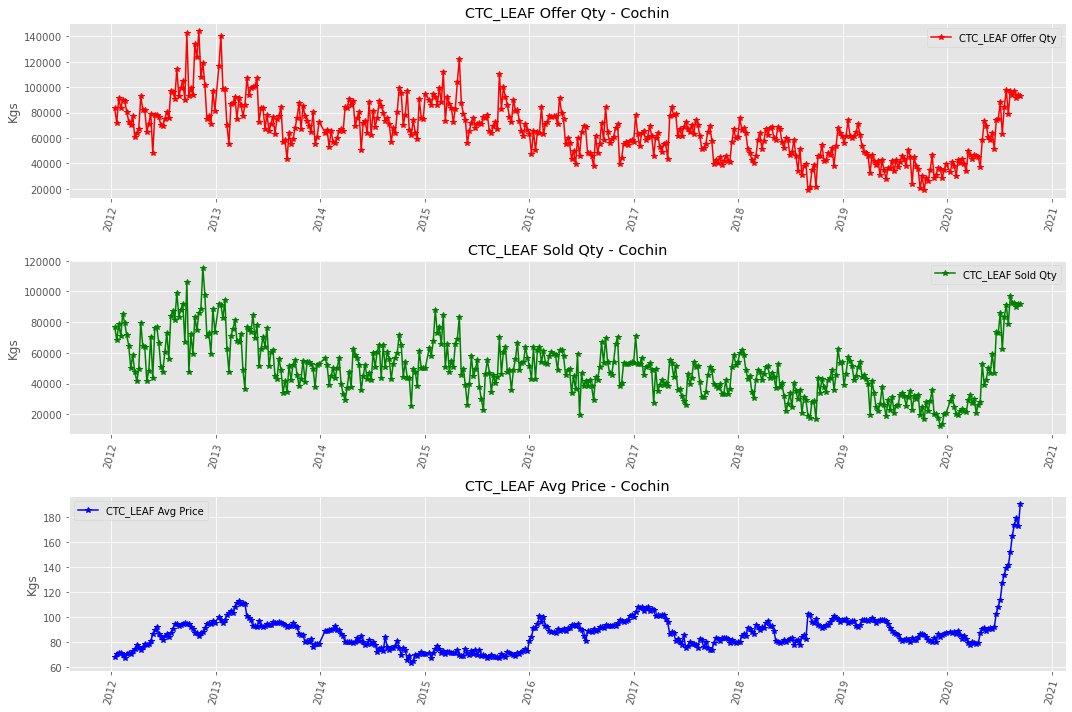

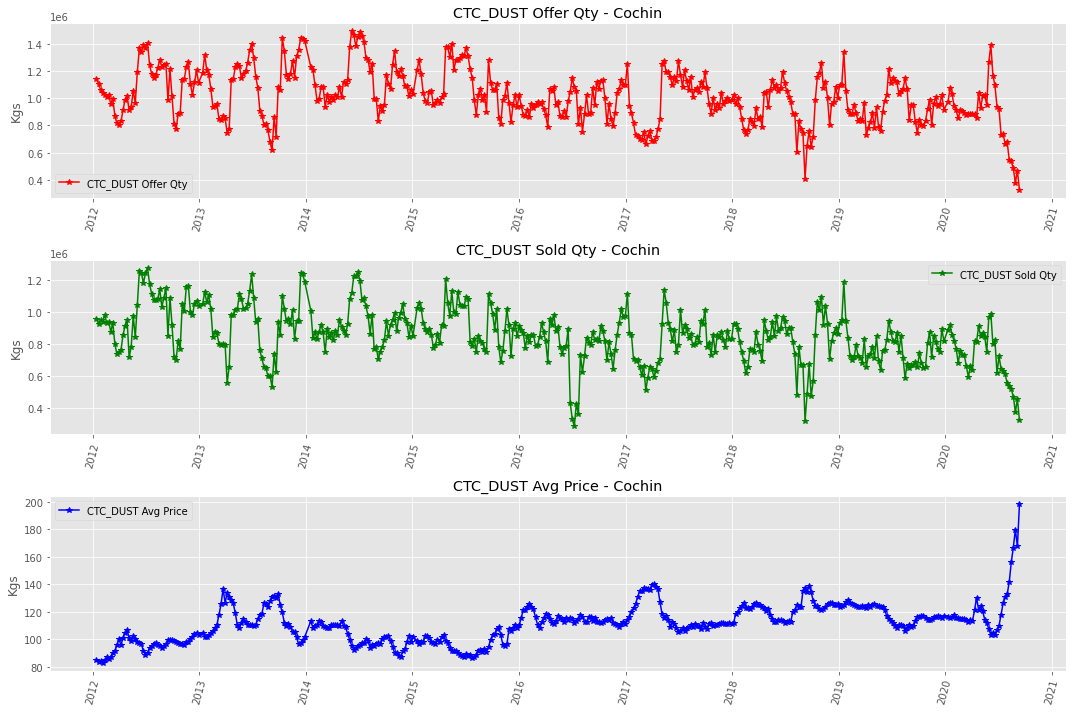

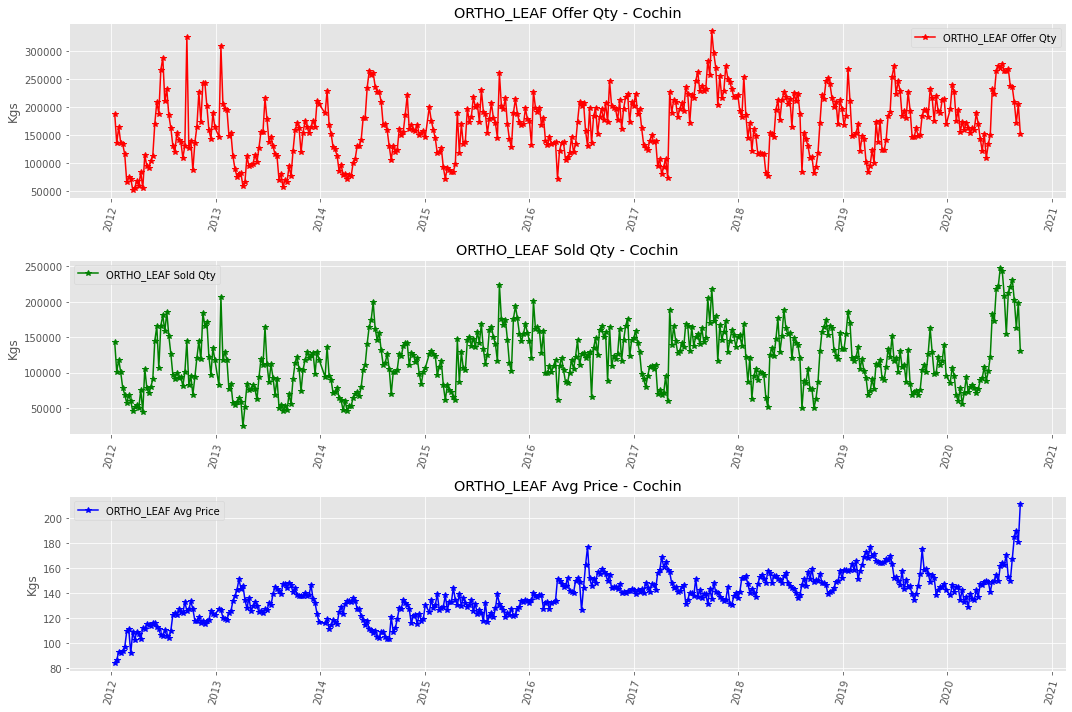

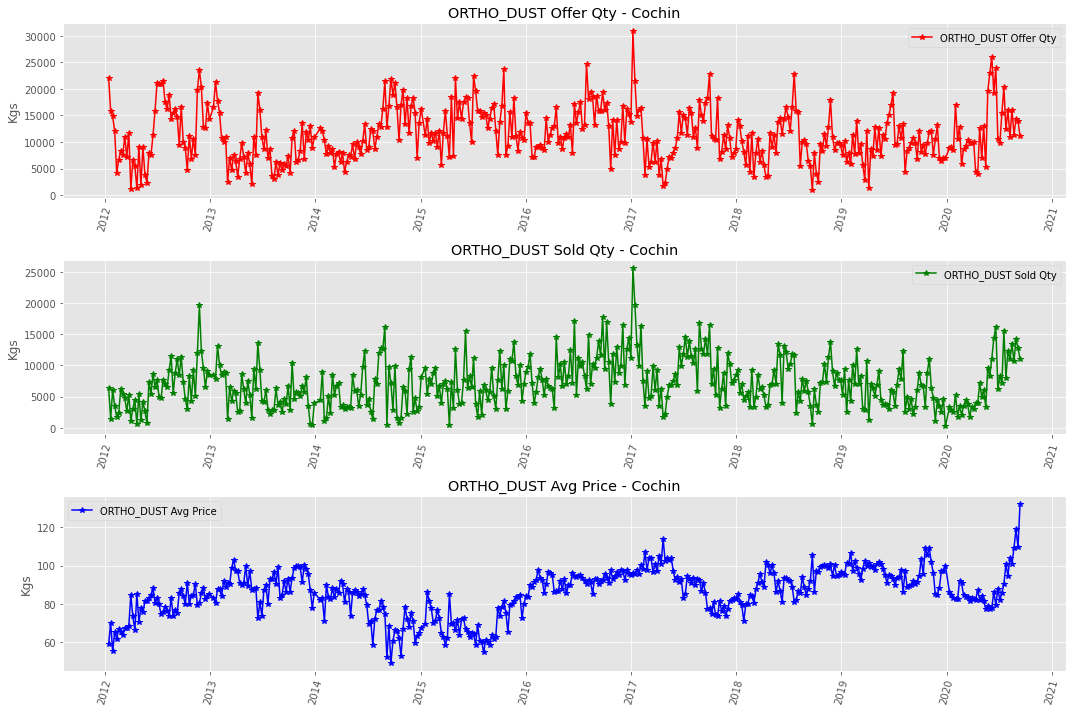

In [12]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

## Univariate

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 52 values followed by one value (for the output) along our time-series data.

In [13]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '11-Jul-20', '18-Jul-20', '25-Jul-20', '1-Aug-20', '8-Aug-20',
       '15-Aug-20', '22-Aug-20', '29-Aug-20', '5-Sep-20', '12-Sep-20'],
      dtype='object', name='week_ending', length=448)

In [14]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [20]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [21]:
df_CHN_CTC_leaf

year  serial_no  ctc_leaf_offer_qty  ctc_leaf_sold_qty  \
week_ending                                                           
14-Jan-12    2012          2            83325.00           77015.00   
21-Jan-12    2012          3            71897.00           68187.00   
28-Jan-12    2012          4            91279.00           78695.00   
4-Feb-12     2012          5            83746.00           71188.00   
11-Feb-12    2012          6            89650.00           85480.00   
...           ...        ...                 ...                ...   
15-Aug-20    2020         33            93637.00           92640.00   
22-Aug-20    2020         34            96829.00           92338.00   
29-Aug-20    2020         35            91799.00           89785.00   
5-Sep-20     2020         36            94088.33           91587.67   
12-Sep-20    2020         37            93485.00           91607.00   

             ctc_leaf_avg_price  
week_ending                      
14-Jan-12                 68.03  
21-Jan-12                 70.11  
28-Jan-12                 70.73  
4-Feb-12                  70.63  
11-Feb-12                 69.23  
...                         ...  
15-Aug-20                165.10  
22-Aug-20                174.03  
29-Aug-20                179.36  
5-Sep-20                 172.83  
12-Sep-20                190.66  

[448 rows x 5 columns]

In [22]:
n_prev = 6

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

((409, 6, 1), (27, 6, 1), (409,), (27,))

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [18]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [15]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.Dropout(0.1))

LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
LSTM_price_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 52)             11232     
_________________________________________________________________
dropout (Dropout)            (None, 6, 52)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 52)                21840     
_________________________________________________________________
dense (Dense)                (None, 1)                 53        
Total params: 33,125
Trainable params: 33,125
Non-trainable params: 0
_________________________________________________________________


In [17]:
LSTM_price_model_history = LSTM_price_model.fit(x_train, y_train, batch_size=10, epochs=300)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
409/409 [==============================] - 3s 8ms/sample - loss: 6618.0095
Epoch 2/300
409/409 [==============================] - 1s 2ms/sample - loss: 5513.2301
Epoch 3/300
409/409 [==============================] - 1s 2ms/sample - loss: 5129.9198
Epoch 4/300
409/409 [==============================] - 1s 2ms/sample - loss: 4804.4079
Epoch 5/300
409/409 [==============================] - 1s 2ms/sample - loss: 4500.6992
Epoch 6/300
409/409 [==============================] - 1s 2ms/sample - loss: 4216.8538
Epoch 7/300
409/409 [==============================] - 1s 2ms/sample - loss: 3950.6132
Epoch 8/300
409/409 [==============================] - 1s 2ms/sample - loss: 3699.5654
Epoch 9/300
409/409 [==============================] - 1s 2ms/sample - loss: 3463.1022
Epoch 10/300
409/409 [==============================] - 1s 2ms/sample - loss: 3238.9916
Epoch 11/300
409/409 [=============

409/409 [==============================] - 1s 2ms/sample - loss: 109.4206
Epoch 92/300
409/409 [==============================] - 1s 2ms/sample - loss: 109.4217
Epoch 93/300
409/409 [==============================] - 1s 2ms/sample - loss: 109.4444
Epoch 94/300
409/409 [==============================] - 1s 2ms/sample - loss: 109.4241
Epoch 95/300
409/409 [==============================] - 1s 2ms/sample - loss: 109.4282
Epoch 96/300
409/409 [==============================] - 1s 2ms/sample - loss: 105.3843
Epoch 97/300
409/409 [==============================] - 1s 2ms/sample - loss: 114.2650
Epoch 98/300
409/409 [==============================] - 1s 2ms/sample - loss: 107.6366
Epoch 99/300
409/409 [==============================] - 1s 2ms/sample - loss: 99.7233
Epoch 100/300
409/409 [==============================] - 1s 2ms/sample - loss: 85.6617
Epoch 101/300
409/409 [==============================] - 1s 2ms/sample - loss: 71.7145
Epoch 102/300
409/409 [==============================] - 

409/409 [==============================] - 1s 2ms/sample - loss: 10.9403
Epoch 280/300
409/409 [==============================] - 1s 2ms/sample - loss: 10.9839
Epoch 281/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.9635
Epoch 282/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.1314
Epoch 283/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.8361
Epoch 284/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.8330
Epoch 285/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.3016
Epoch 286/300
409/409 [==============================] - 1s 2ms/sample - loss: 10.8827
Epoch 287/300
409/409 [==============================] - 1s 2ms/sample - loss: 12.7278
Epoch 288/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.3820
Epoch 289/300
409/409 [==============================] - 1s 2ms/sample - loss: 11.5801
Epoch 290/300
409/409 [==============================] - 

In [18]:
# ## Pickle the model
# # Save the Modle to file in the current working directory
# timestamp =   str(datetime.now().year) + '_'\
#             + str(datetime.now().month).zfill(2) + '_'\
#             + str(datetime.now().day).zfill(2) + '_'\
#             + str(datetime.now().hour).zfill(2) + '_'\
#             + str(datetime.now().minute).zfill(2) + '_'\
#             + str(datetime.now().second).zfill(2)


# pickled_model_filename = '../Models/LSTM_price_model_' + LSTM_price_model.name + '_' + timestamp + '.pkl'  

# with open(pickled_model_filename, 'wb') as file:  
#     pickle.dump(LSTM_price_model, file)

# # Load the Model back from file
# with open(pickled_model_filename, 'rb') as file:  
#     pickled_LSTM_price_model = pickle.load(file)

# pickled_LSTM_price_model

## Predictions from LSTM Univariate

In [19]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[ 86.566925],
       [ 83.68038 ],
       [ 81.96615 ],
       [ 83.091125],
       [ 82.91676 ],
       [ 82.50559 ],
       [ 82.80858 ],
       [ 89.772064],
       [ 94.21246 ],
       [ 94.99487 ],
       [ 92.54536 ],
       [ 93.63965 ],
       [ 94.59136 ],
       [ 93.68958 ],
       [ 95.68529 ],
       [103.77274 ],
       [107.4289  ],
       [107.74539 ],
       [107.84083 ],
       [107.87297 ],
       [107.88202 ],
       [107.884964],
       [107.88692 ],
       [107.88896 ],
       [107.88986 ],
       [107.89053 ],
       [107.89075 ]], dtype=float32)

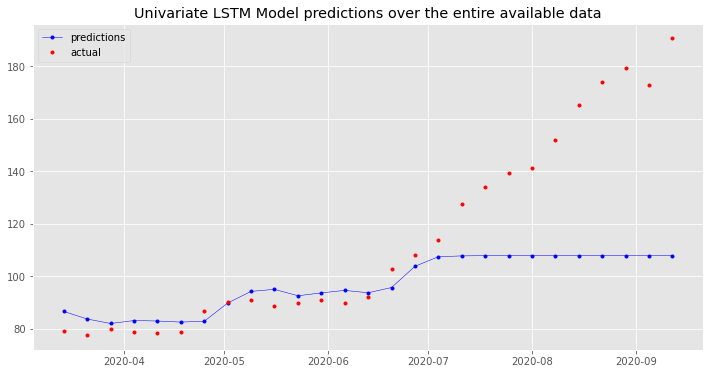

In [20]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the entire available data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata_entire_available' + get_timestamp())
ax.legend();

In [21]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [22]:
# Calaculate MAPE
print(f'MAPE for known data (before 2020) = {mape(price_series, y_pred)}')

MAPE for known data (before 2020) = 19.217719068754256


In [23]:
LSTM_price_model_history.history

{'loss': [6618.009474327629,
  5513.230052099251,
  5129.919814429249,
  4804.407858104752,
  4500.699222331525,
  4216.853821248472,
  3950.6131791765356,
  3699.565356863157,
  3463.10220657759,
  3238.9915565546685,
  3027.621798713516,
  2827.3799789167556,
  2638.5193891828394,
  2460.322685260353,
  2291.510184663432,
  2132.67949648533,
  1983.0878509297638,
  1841.8819209987203,
  1709.4015504421989,
  1584.7726253891924,
  1468.1651853081066,
  1358.4690111528691,
  1255.862917426746,
  1160.18935403614,
  1070.616891725722,
  987.315588916135,
  909.7764941824095,
  837.6051765572471,
  770.7752718377521,
  708.8506684618067,
  651.5660430236667,
  599.1307074586454,
  550.2484732257125,
  505.6175311025606,
  464.8661384116175,
  427.2468390802882,
  393.2662762406403,
  362.0228691567419,
  333.7241031115096,
  308.0540133898299,
  285.02554287712263,
  264.11405379614797,
  245.26602930194883,
  228.40638516526352,
  213.46267013736343,
  199.8571841885816,
  188.017391699

In [24]:
def plot_train_history(history, title):
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(20,10))

    plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


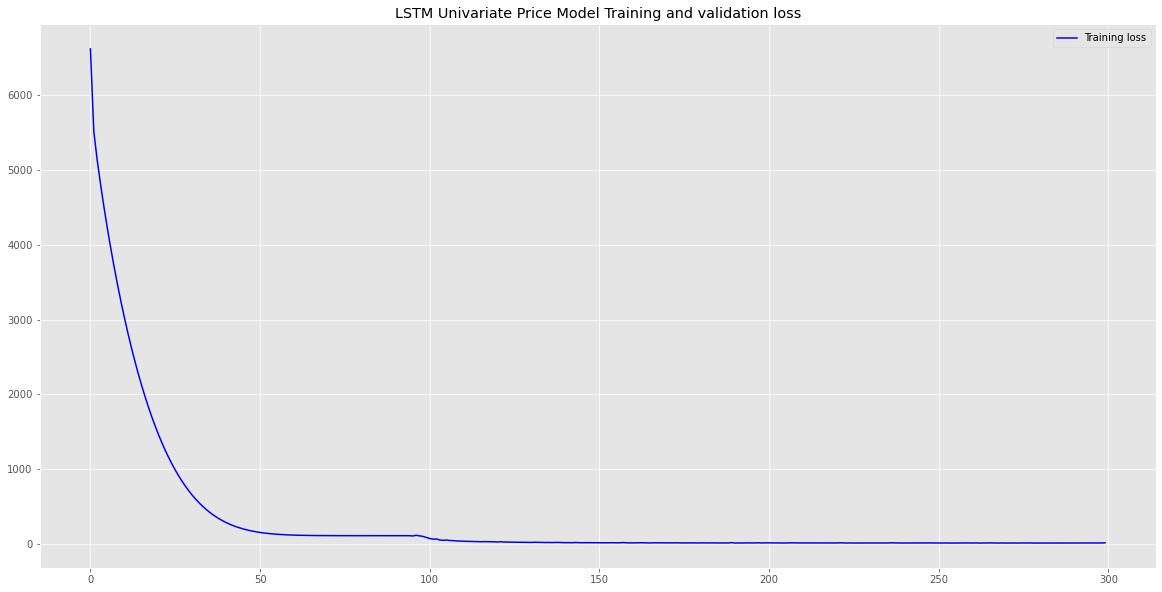

In [25]:
plot_train_history(LSTM_price_model_history, 'LSTM Univariate Price Model Training and validation loss')

In [27]:
288 * 10000 /300000

9.6

## Try again with scaled data

In [47]:
# Data Loader Parameters
BATCH_SIZE = 52
BUFFER_SIZE = 10 # 10000
TRAIN_SPLIT = 288 # ~ 70:30 300K out of 420K

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 6


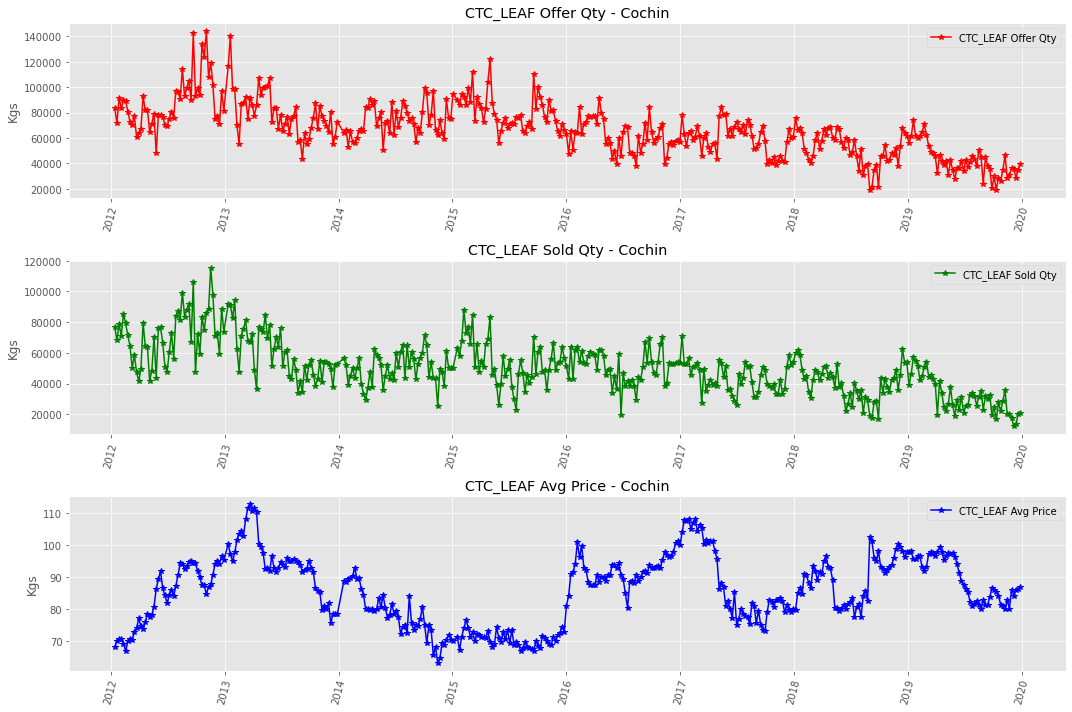

In [40]:
# Load the data again
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
# # chop out 2020 data
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# Plot it
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')

In [41]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)


In [42]:
df_CHN_CTC_leaf.info()


<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 14-Jan-12 to 28-Dec-19
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                412 non-null    int64  
 1   serial_no           412 non-null    int64  
 2   ctc_leaf_offer_qty  412 non-null    float64
 3   ctc_leaf_sold_qty   412 non-null    float64
 4   ctc_leaf_avg_price  412 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.3+ KB


In [43]:
# Prepare the data for only the average price

In [35]:
uni_data = df_CHN_CTC_leaf['ctc_leaf_avg_price']
uni_data.index = df_CHN_CTC_leaf.index

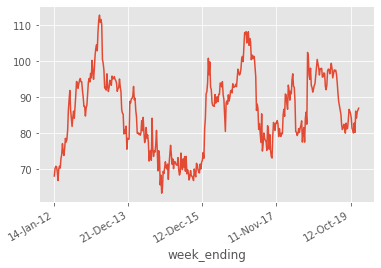

In [36]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [45]:
# Scale only the train data
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [48]:
# Create the data for the univariate model which will be given the last n_prev weeks' price observations, 
# and needs to learn to predict the temperature at the next week.
univariate_past_history = n_prev
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [49]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)


print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(412,)
[-1.44628993 -1.26760032 -1.21433707 -1.22292792 -1.34319977]

Out
(282, 6, 1)
0.6844660194174758


In [50]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (6, 1)
[[-1.44628993]
 [-1.26760032]
 [-1.21433707]
 [-1.22292792]
 [-1.34319977]
 [-1.5545346 ]]

 Target temperature to predict. Shape: ()
-1.2839229297660377


In [51]:
def create_time_steps(length):
    return list(range(-length, 0))

In [52]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

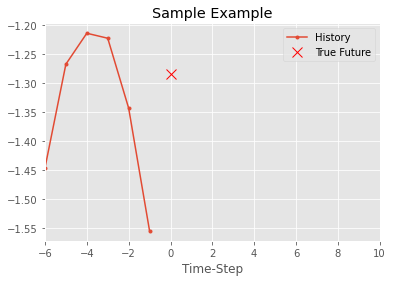

In [53]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [54]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

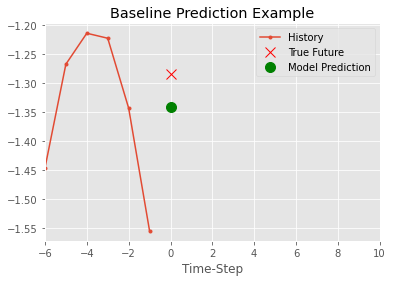

In [55]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [56]:
# Let's now use tf.data to shuffle, batch, and cache the dataset.
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [57]:
x_train_uni.shape

(282, 6, 1)

In [66]:
# Set up the model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [67]:
# LSTM_price_model = keras.Sequential()
# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))
# LSTM_price_model.add(keras.layers.Dropout(0.1))
# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))
# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [70]:
for x, y in val_univariate.take(1):
    
    print(x), print(y)
    
    
    
#     print(simple_lstm_model.predict(x, steps=1).shape)

Tensor("IteratorGetNext_6:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14:0", shape=(?,

Tensor("IteratorGetNext_200:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_200:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_201:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_201:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_202:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_202:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_203:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_203:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_204:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_204:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_205:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_205:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_206:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_206:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_207:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_207:1", shape=(?,), dtype=float64)
Tensor("Iterator

Tensor("IteratorGetNext_400:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_400:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_401:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_401:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_402:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_402:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_403:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_403:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_404:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_404:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_405:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_405:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_406:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_406:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_407:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_407:1", shape=(?,), dtype=float64)
Tensor("Iterator

Tensor("IteratorGetNext_625:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_625:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_626:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_626:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_627:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_627:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_628:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_628:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_629:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_629:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_630:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_630:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_631:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_631:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_632:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_632:1", shape=(?,), dtype=float64)
Tensor("Iterator

Tensor("IteratorGetNext_848:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_848:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_849:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_849:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_850:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_850:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_851:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_851:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_852:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_852:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_853:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_853:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_854:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_854:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_855:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_855:1", shape=(?,), dtype=float64)
Tensor("Iterator

Tensor("IteratorGetNext_967:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_967:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_968:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_968:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_969:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_969:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_970:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_970:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_971:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_971:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_972:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_972:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_973:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_973:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_974:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_974:1", shape=(?,), dtype=float64)
Tensor("Iterator

Tensor("IteratorGetNext_1180:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1180:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1181:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1181:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1182:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1182:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1183:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1183:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1184:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1184:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1185:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1185:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1186:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1186:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1187:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1187:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_1403:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1403:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1404:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1404:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1405:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1405:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1406:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1406:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1407:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1407:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1408:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1408:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1409:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1409:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1410:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1410:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_1628:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1628:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1629:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1629:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1630:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1630:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1631:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1631:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1632:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1632:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1633:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1633:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1634:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1634:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1635:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1635:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_1848:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1848:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1849:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1849:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1850:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1850:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1851:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1851:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1852:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1852:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1853:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1853:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1854:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1854:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_1855:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_1855:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_2072:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2072:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2073:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2073:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2074:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2074:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2075:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2075:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2076:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2076:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2077:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2077:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2078:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2078:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2079:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2079:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_2295:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2295:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2296:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2296:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2297:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2297:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2298:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2298:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2299:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2299:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2300:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2300:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2301:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2301:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2302:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2302:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_2515:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2515:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2516:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2516:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2517:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2517:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2518:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2518:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2519:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2519:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2520:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2520:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2521:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2521:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2522:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2522:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_2616:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2616:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2617:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2618:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2618:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2619:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2619:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2620:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2620:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2621:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2621:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2622:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2622:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2623:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2623:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_2829:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2829:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2830:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2830:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2831:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2831:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2832:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2832:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2833:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2833:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2834:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2834:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2835:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2835:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_2836:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_2836:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_3054:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3054:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3055:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3055:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3056:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3056:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3057:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3057:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3058:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3058:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3059:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3059:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3060:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3060:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3061:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3061:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_3277:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3277:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3278:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3278:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3279:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3279:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3280:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3280:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3281:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3281:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3282:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3282:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3283:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3283:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3284:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3284:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_3483:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3483:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3484:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3484:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3485:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3485:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3486:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3486:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3487:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3487:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3488:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3488:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3489:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3489:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3490:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3490:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_3683:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3683:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3684:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3684:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3685:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3685:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3686:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3686:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3687:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3687:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3688:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3688:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3689:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3689:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3690:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3690:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_3886:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3886:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3887:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3887:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3888:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3888:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3889:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3889:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3890:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3890:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3891:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3891:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3892:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3892:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_3893:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_3893:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_4096:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4096:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4097:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4097:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4098:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4098:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4099:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4099:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4100:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4100:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4101:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4101:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4102:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4102:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4103:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4103:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_4307:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4307:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4308:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4308:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4309:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4309:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4310:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4310:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4311:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4311:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4312:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4312:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4313:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4313:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4314:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4314:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_4510:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4510:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4511:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4511:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4512:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4512:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4513:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4513:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4514:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4514:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4515:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4515:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4516:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4516:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4517:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4517:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_4695:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4695:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4696:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4696:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4697:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4697:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4698:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4698:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4699:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4699:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4700:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4700:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4701:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4701:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4702:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4702:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_4928:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4928:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4929:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4930:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4930:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4931:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4931:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4932:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4932:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4933:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4933:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4934:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4934:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_4935:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_4935:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_5109:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5109:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5110:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5110:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5111:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5111:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5112:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5112:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5113:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5113:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5114:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5114:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5115:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5115:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5116:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5116:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_5331:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5331:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5332:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5332:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5333:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5333:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5334:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5334:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5335:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5335:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5336:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5336:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5337:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5337:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5338:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5338:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_5556:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5556:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5557:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5557:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5558:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5558:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5559:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5559:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5560:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5560:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5561:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5561:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5562:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5562:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5563:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5563:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_5770:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5770:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5771:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5771:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5772:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5772:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5773:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5773:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5774:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5774:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5775:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5775:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5776:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5776:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5777:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5777:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_5984:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5984:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5985:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5985:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5986:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5986:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5987:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5987:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5988:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5988:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5989:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5989:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5990:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5990:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_5991:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_5991:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_6200:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6200:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6201:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6201:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6202:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6202:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6203:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6203:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6204:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6204:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6205:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6205:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6206:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6206:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6207:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6207:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_6412:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6412:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6413:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6413:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6414:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6414:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6415:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6415:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6416:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6416:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6417:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6417:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6418:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6418:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6419:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6419:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_6623:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6623:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6624:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6624:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6625:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6625:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6626:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6626:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6627:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6627:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6628:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6628:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6629:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6629:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6630:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6630:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_6843:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6843:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6844:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6844:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6845:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6845:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6846:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6846:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6847:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6847:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6848:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6848:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6849:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6849:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_6850:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_6850:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_7061:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7061:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7062:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7062:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7063:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7063:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7064:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7064:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7065:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7065:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7066:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7066:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7067:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7067:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7068:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7068:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_7242:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7242:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7243:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7243:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7244:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7244:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7245:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7245:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7246:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7246:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7247:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7247:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7248:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7248:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7249:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7249:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_7497:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7497:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7498:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7498:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7499:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7499:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7500:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7500:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7501:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7501:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7502:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7502:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7503:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7503:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7504:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7504:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_7709:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7709:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7710:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7710:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7711:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7711:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7712:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7712:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7713:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7713:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7714:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7714:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7715:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7715:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7716:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7716:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_7913:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7913:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7914:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7914:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7915:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7915:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7916:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7916:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7917:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7917:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7918:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7918:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7919:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7919:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_7920:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_7920:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_8134:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8134:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8135:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8135:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8136:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8136:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8137:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8137:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8138:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8138:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8139:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8139:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8140:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8140:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8141:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8141:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_8347:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8347:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8348:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8348:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8349:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8349:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8350:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8350:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8351:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8351:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8352:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8352:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8353:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8353:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8354:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8354:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_8566:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8566:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8567:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8567:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8568:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8568:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8569:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8569:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8570:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8570:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8571:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8571:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8572:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8572:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8573:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8573:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_8782:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8782:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8783:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8783:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8784:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8784:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8785:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8785:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8786:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8786:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8787:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8787:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8788:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8788:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8789:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8789:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_8977:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8977:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8978:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8978:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8979:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8979:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8980:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8980:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8981:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8981:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8982:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8982:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8983:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8983:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_8984:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_8984:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_9157:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9157:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9158:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9158:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9159:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9159:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9160:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9160:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9161:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9161:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9162:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9162:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9163:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9163:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9164:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9164:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_9350:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9350:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9351:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9351:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9352:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9352:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9353:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9353:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9354:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9354:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9355:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9355:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9356:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9356:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9357:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9357:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_9549:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9549:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9550:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9550:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9551:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9551:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9552:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9552:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9553:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9553:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9554:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9554:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9555:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9555:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9556:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9556:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_9756:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9756:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9757:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9757:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9758:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9758:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9759:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9759:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9760:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9760:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9761:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9761:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9762:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9762:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9763:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9763:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_9965:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9965:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9966:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9966:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9967:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9967:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9968:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9968:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9969:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9969:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9970:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9970:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9971:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9971:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_9972:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_9972:1", shape=(?,), dtype=float64)


Tensor("IteratorGetNext_10154:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10154:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10155:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10155:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10156:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10156:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10157:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10157:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10158:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10158:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10159:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10159:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10160:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10160:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10161:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10161:1", shape=(?,),

Tensor("IteratorGetNext_10345:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10345:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10346:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10346:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10347:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10347:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10348:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10348:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10349:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10349:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10350:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10350:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10351:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10351:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10352:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10352:1", shape=(?,),

Tensor("IteratorGetNext_10522:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10522:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10523:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10523:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10524:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10524:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10525:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10525:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10526:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10526:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10527:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10527:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10528:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10528:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10529:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10529:1", shape=(?,),

Tensor("IteratorGetNext_10587:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10587:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10588:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10588:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10589:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10589:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10590:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10590:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10591:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10591:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10592:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10592:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10593:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10593:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10594:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10594:1", shape=(?,),

Tensor("IteratorGetNext_10783:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10783:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10784:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10784:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10785:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10785:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10786:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10786:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10787:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10787:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10788:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10788:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10789:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10789:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_10790:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10790:1", shape=(?,),

Tensor("IteratorGetNext_10999:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_10999:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11000:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11000:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11001:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11001:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11002:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11002:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11003:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11003:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11004:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11004:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11005:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11005:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11006:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11006:1", shape=(?,),

Tensor("IteratorGetNext_11185:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11185:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11186:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11186:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11187:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11187:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11188:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11188:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11189:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11189:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11190:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11190:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11191:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11191:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11192:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11192:1", shape=(?,),

Tensor("IteratorGetNext_11390:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11390:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11391:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11391:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11392:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11392:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11393:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11393:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11394:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11394:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11395:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11395:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11396:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11396:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11397:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11397:1", shape=(?,),

Tensor("IteratorGetNext_11594:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11594:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11595:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11595:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11596:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11596:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11597:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11597:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11598:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11598:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11599:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11599:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11600:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11600:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11601:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11601:1", shape=(?,),

Tensor("IteratorGetNext_11812:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11812:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11813:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11813:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11814:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11814:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11815:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11815:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11816:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11816:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11817:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11817:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11818:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11818:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11819:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11819:1", shape=(?,),

Tensor("IteratorGetNext_11996:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11996:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11997:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11997:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11998:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11998:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_11999:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_11999:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12000:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12000:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12001:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12001:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12002:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12002:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12003:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12003:1", shape=(?,),

Tensor("IteratorGetNext_12173:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12173:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12174:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12174:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12175:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12175:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12176:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12176:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12177:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12177:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12178:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12178:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12179:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12179:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12180:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12180:1", shape=(?,),

Tensor("IteratorGetNext_12386:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12386:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12387:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12387:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12388:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12388:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12389:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12389:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12390:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12390:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12391:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12391:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12392:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12392:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12393:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12393:1", shape=(?,),

Tensor("IteratorGetNext_12570:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12570:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12571:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12571:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12572:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12572:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12573:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12573:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12574:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12574:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12575:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12575:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12576:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12576:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12577:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12577:1", shape=(?,),

Tensor("IteratorGetNext_12749:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12749:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12750:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12750:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12751:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12751:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12752:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12752:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12753:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12753:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12754:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12754:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12755:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12755:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12756:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12756:1", shape=(?,),

Tensor("IteratorGetNext_12928:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12928:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12929:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12930:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12930:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12931:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12931:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12932:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12932:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12933:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12933:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12934:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12934:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_12935:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_12935:1", shape=(?,),

Tensor("IteratorGetNext_13105:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13105:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13106:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13106:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13107:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13107:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13108:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13108:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13109:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13109:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13110:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13110:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13111:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13111:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13112:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13112:1", shape=(?,),

Tensor("IteratorGetNext_13282:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13282:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13283:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13283:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13284:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13284:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13285:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13285:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13286:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13286:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13287:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13287:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13288:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13288:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13289:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13289:1", shape=(?,),

Tensor("IteratorGetNext_13460:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13460:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13461:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13461:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13462:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13462:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13463:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13463:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13464:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13464:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13465:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13465:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13466:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13466:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13467:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13467:1", shape=(?,),

Tensor("IteratorGetNext_13639:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13639:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13640:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13640:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13641:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13641:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13642:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13642:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13643:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13643:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13644:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13644:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13645:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13645:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13646:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13646:1", shape=(?,),

Tensor("IteratorGetNext_13820:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13820:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13821:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13821:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13822:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13822:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13823:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13823:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13824:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13824:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13825:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13825:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13826:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13826:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_13827:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_13827:1", shape=(?,),

Tensor("IteratorGetNext_14000:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14000:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14001:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14001:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14002:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14002:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14003:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14003:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14004:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14004:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14005:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14005:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14006:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14006:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14007:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14007:1", shape=(?,),

Tensor("IteratorGetNext_14179:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14179:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14180:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14180:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14181:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14181:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14182:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14182:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14183:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14183:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14184:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14184:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14185:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14185:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14186:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14186:1", shape=(?,),

Tensor("IteratorGetNext_14373:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14373:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14374:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14374:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14375:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14375:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14376:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14376:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14377:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14377:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14378:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14378:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14379:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14379:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14380:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14380:1", shape=(?,),

Tensor("IteratorGetNext_14587:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14587:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14588:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14588:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14589:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14589:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14590:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14590:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14591:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14591:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14592:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14592:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14593:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14593:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14594:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14594:1", shape=(?,),

Tensor("IteratorGetNext_14693:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14693:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14694:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14694:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14695:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14695:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14696:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14696:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14697:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14697:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14698:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14698:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14699:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14699:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14700:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14700:1", shape=(?,),

Tensor("IteratorGetNext_14878:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14878:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14879:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14879:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14880:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14880:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14881:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14881:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14882:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14882:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14883:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14883:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14884:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14884:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_14885:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_14885:1", shape=(?,),

Tensor("IteratorGetNext_15090:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15090:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15091:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15091:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15092:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15092:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15093:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15093:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15094:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15094:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15095:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15095:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15096:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15096:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15097:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15097:1", shape=(?,),

Tensor("IteratorGetNext_15297:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15297:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15298:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15298:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15299:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15299:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15300:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15300:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15301:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15301:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15302:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15302:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15303:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15303:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15304:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15304:1", shape=(?,),

Tensor("IteratorGetNext_15518:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15518:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15519:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15519:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15520:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15520:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15521:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15521:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15522:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15522:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15523:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15523:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15524:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15524:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15525:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15525:1", shape=(?,),

Tensor("IteratorGetNext_15737:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15737:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15738:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15738:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15739:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15739:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15740:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15740:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15741:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15741:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15742:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15742:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15743:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15743:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15744:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15744:1", shape=(?,),

Tensor("IteratorGetNext_15934:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15934:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15935:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15935:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15936:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15936:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15937:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15937:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15938:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15938:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15939:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15939:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15940:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15940:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_15941:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_15941:1", shape=(?,),

Tensor("IteratorGetNext_16111:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16111:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16112:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16112:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16113:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16113:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16114:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16114:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16115:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16115:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16116:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16116:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16117:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16117:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16118:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16118:1", shape=(?,),

Tensor("IteratorGetNext_16295:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16295:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16296:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16296:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16297:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16297:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16298:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16298:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16299:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16299:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16300:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16300:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16301:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16301:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16302:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16302:1", shape=(?,),

Tensor("IteratorGetNext_16513:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16513:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16514:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16514:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16515:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16515:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16516:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16516:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16517:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16517:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16518:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16518:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16519:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16519:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16520:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16520:1", shape=(?,),

Tensor("IteratorGetNext_16722:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16722:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16723:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16723:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16724:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16724:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16725:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16725:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16726:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16726:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16727:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16727:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16728:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16728:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16729:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16729:1", shape=(?,),

Tensor("IteratorGetNext_16929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16929:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16930:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16930:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16931:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16931:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16932:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16932:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16933:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16933:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16934:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16934:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16935:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16935:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_16936:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_16936:1", shape=(?,),

Tensor("IteratorGetNext_17143:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17143:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17144:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17144:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17145:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17145:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17146:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17146:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17147:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17147:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17148:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17148:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17149:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17149:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17150:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17150:1", shape=(?,),

Tensor("IteratorGetNext_17359:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17359:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17360:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17360:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17361:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17361:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17362:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17362:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17363:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17363:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17364:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17364:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17365:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17365:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17366:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17366:1", shape=(?,),

Tensor("IteratorGetNext_17547:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17547:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17548:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17548:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17549:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17549:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17550:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17550:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17551:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17551:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17552:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17552:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17553:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17553:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17554:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17554:1", shape=(?,),

Tensor("IteratorGetNext_17724:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17724:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17725:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17725:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17726:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17726:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17727:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17727:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17728:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17728:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17729:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17729:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17730:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17730:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17731:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17731:1", shape=(?,),

Tensor("IteratorGetNext_17905:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17905:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17906:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17906:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17907:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17907:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17908:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17908:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17909:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17909:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17910:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17910:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17911:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17911:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_17912:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_17912:1", shape=(?,),

Tensor("IteratorGetNext_18074:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18075:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18075:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18076:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18076:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18077:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18077:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18078:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18078:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18079:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18079:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18080:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18080:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18081:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18081:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18082:0", shape=(?, 6, 1),

Tensor("IteratorGetNext_18262:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18262:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18263:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18263:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18264:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18264:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18265:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18265:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18266:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18266:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18267:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18267:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18268:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18268:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18269:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18269:1", shape=(?,),

Tensor("IteratorGetNext_18439:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18439:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18440:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18440:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18441:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18441:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18442:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18442:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18443:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18443:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18444:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18444:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18445:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18445:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18446:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18446:1", shape=(?,),

Tensor("IteratorGetNext_18611:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18611:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18612:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18612:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18613:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18613:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18614:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18614:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18615:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18615:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18616:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18616:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18617:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18618:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18618:1", shape=(?,),

Tensor("IteratorGetNext_18789:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18789:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18790:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18790:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18791:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18791:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18792:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18792:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18793:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18793:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18794:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18794:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18795:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18795:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18796:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18796:1", shape=(?,),

Tensor("IteratorGetNext_18988:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18988:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18989:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18989:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18990:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18990:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18991:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18991:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18992:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18992:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18993:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18993:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18994:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18994:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_18995:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_18995:1", shape=(?,),

Tensor("IteratorGetNext_19207:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19207:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19208:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19208:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19209:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19209:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19210:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19210:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19211:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19211:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19212:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19212:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19213:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19213:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19214:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19214:1", shape=(?,),

Tensor("IteratorGetNext_19416:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19416:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19417:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19417:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19418:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19418:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19419:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19419:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19420:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19420:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19421:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19421:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19422:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19422:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19423:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19423:1", shape=(?,),

Tensor("IteratorGetNext_19610:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19610:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19611:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19611:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19612:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19612:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19613:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19613:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19614:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19614:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19615:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19615:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19616:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19616:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19617:1", shape=(?,),

Tensor("IteratorGetNext_19735:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19735:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19736:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19736:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19737:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19737:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19738:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19738:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19739:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19739:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19740:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19740:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19741:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19741:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19742:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19742:1", shape=(?,),

Tensor("IteratorGetNext_19925:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19925:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19926:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19926:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19927:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19927:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19928:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19928:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19929:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19930:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19930:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19931:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19931:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_19932:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_19932:1", shape=(?,),

Tensor("IteratorGetNext_20129:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20129:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20130:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20130:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20131:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20131:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20132:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20132:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20133:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20133:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20134:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20134:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20135:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20135:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20136:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20136:1", shape=(?,),

Tensor("IteratorGetNext_20312:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20312:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20313:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20313:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20314:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20314:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20315:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20315:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20316:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20316:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20317:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20317:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20318:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20318:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20319:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20319:1", shape=(?,),

Tensor("IteratorGetNext_20494:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20494:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20495:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20495:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20496:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20496:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20497:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20497:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20498:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20498:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20499:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20499:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20500:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20500:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20501:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20501:1", shape=(?,),

Tensor("IteratorGetNext_20677:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20677:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20678:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20678:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20679:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20679:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20680:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20680:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20681:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20681:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20682:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20682:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20683:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20683:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20684:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20684:1", shape=(?,),

Tensor("IteratorGetNext_20864:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20864:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20865:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20865:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20866:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20866:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20867:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20867:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20868:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20868:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20869:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20869:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20870:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20870:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_20871:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_20871:1", shape=(?,),

Tensor("IteratorGetNext_21048:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21048:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21049:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21049:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21050:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21050:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21051:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21051:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21052:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21052:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21053:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21053:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21054:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21054:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21055:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21055:1", shape=(?,),

Tensor("IteratorGetNext_21258:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21258:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21259:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21259:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21260:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21260:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21261:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21261:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21262:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21262:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21263:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21263:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21264:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21264:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21265:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21265:1", shape=(?,),

Tensor("IteratorGetNext_21456:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21456:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21457:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21457:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21458:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21458:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21459:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21459:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21460:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21460:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21461:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21461:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21462:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21462:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21463:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21463:1", shape=(?,),

Tensor("IteratorGetNext_21666:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21666:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21667:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21667:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21668:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21668:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21669:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21669:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21670:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21670:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21671:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21671:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21672:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21672:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21673:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21673:1", shape=(?,),

Tensor("IteratorGetNext_21881:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21881:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21882:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21882:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21883:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21883:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21884:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21884:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21885:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21885:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21886:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21886:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21887:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21887:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_21888:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_21888:1", shape=(?,),

Tensor("IteratorGetNext_22100:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22100:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22101:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22101:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22102:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22102:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22103:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22103:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22104:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22104:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22105:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22105:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22106:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22106:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22107:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22107:1", shape=(?,),

Tensor("IteratorGetNext_22299:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22299:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22300:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22300:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22301:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22301:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22302:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22302:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22303:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22303:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22304:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22304:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22305:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22305:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22306:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22306:1", shape=(?,),

Tensor("IteratorGetNext_22521:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22521:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22522:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22522:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22523:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22523:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22524:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22524:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22525:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22525:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22526:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22526:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22527:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22527:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22528:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22528:1", shape=(?,),

Tensor("IteratorGetNext_22744:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22744:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22745:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22745:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22746:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22746:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22747:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22747:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22748:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22748:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22749:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22749:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22750:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22750:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22751:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22751:1", shape=(?,),

Tensor("IteratorGetNext_22964:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22964:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22965:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22965:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22966:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22966:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22967:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22967:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22968:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22968:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22969:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22969:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22970:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22970:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_22971:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_22971:1", shape=(?,),

Tensor("IteratorGetNext_23185:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23185:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23186:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23186:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23187:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23187:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23188:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23188:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23189:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23189:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23190:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23190:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23191:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23191:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23192:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23192:1", shape=(?,),

Tensor("IteratorGetNext_23395:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23395:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23396:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23396:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23397:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23397:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23398:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23398:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23399:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23399:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23400:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23400:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23401:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23401:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23402:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23402:1", shape=(?,),

Tensor("IteratorGetNext_23613:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23613:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23614:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23614:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23615:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23615:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23616:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23616:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23617:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23618:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23618:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23619:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23619:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23620:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23620:1", shape=(?,),

Tensor("IteratorGetNext_23836:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23836:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23837:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23837:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23838:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23838:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23839:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23839:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23840:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23840:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23841:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23841:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23842:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23842:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_23843:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_23843:1", shape=(?,),

Tensor("IteratorGetNext_24059:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24059:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24060:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24060:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24061:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24061:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24062:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24062:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24063:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24063:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24064:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24064:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24065:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24065:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24066:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24066:1", shape=(?,),

Tensor("IteratorGetNext_24273:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24273:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24274:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24274:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24275:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24275:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24276:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24276:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24277:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24277:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24278:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24278:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24279:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24279:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24280:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24280:1", shape=(?,),

Tensor("IteratorGetNext_24490:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24490:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24491:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24491:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24492:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24492:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24493:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24493:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24494:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24494:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24495:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24495:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24496:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24496:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24497:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24497:1", shape=(?,),

Tensor("IteratorGetNext_24705:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24705:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24706:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24706:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24707:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24707:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24708:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24708:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24709:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24709:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24710:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24710:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24711:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24711:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24712:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24712:1", shape=(?,),

Tensor("IteratorGetNext_24922:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24922:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24923:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24923:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24924:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24924:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24925:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24925:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24926:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24926:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24927:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24927:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24928:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24928:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_24929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_24929:1", shape=(?,),

Tensor("IteratorGetNext_25146:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25146:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25147:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25147:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25148:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25148:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25149:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25149:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25150:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25150:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25151:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25151:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25152:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25152:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25153:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25153:1", shape=(?,),

Tensor("IteratorGetNext_25369:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25369:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25370:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25370:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25371:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25371:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25372:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25372:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25373:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25373:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25374:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25374:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25375:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25375:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25376:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25376:1", shape=(?,),

Tensor("IteratorGetNext_25589:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25589:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25590:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25590:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25591:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25591:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25592:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25592:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25593:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25593:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25594:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25594:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25595:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25595:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25596:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25596:1", shape=(?,),

Tensor("IteratorGetNext_25808:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25808:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25809:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25809:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25810:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25810:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25811:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25811:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25812:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25812:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25813:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25813:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25814:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25814:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_25815:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_25815:1", shape=(?,),

Tensor("IteratorGetNext_26030:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26030:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26031:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26031:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26032:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26032:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26033:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26033:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26034:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26034:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26035:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26035:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26036:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26036:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26037:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26037:1", shape=(?,),

Tensor("IteratorGetNext_26251:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26251:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26252:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26252:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26253:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26253:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26254:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26254:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26255:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26255:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26256:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26256:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26257:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26257:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26258:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26258:1", shape=(?,),

Tensor("IteratorGetNext_26471:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26471:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26472:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26472:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26473:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26473:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26474:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26474:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26475:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26475:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26476:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26476:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26477:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26477:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26478:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26478:1", shape=(?,),

Tensor("IteratorGetNext_26691:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26691:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26692:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26692:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26693:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26693:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26694:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26694:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26695:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26695:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26696:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26696:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26697:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26697:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26698:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26698:1", shape=(?,),

Tensor("IteratorGetNext_26909:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26909:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26910:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26910:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26911:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26911:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26912:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26912:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26913:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26913:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26914:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26914:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26915:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26915:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_26916:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_26916:1", shape=(?,),

Tensor("IteratorGetNext_27134:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27134:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27135:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27135:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27136:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27136:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27137:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27137:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27138:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27138:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27139:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27139:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27140:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27140:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27141:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27141:1", shape=(?,),

Tensor("IteratorGetNext_27353:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27353:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27354:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27354:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27355:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27355:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27356:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27356:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27357:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27357:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27358:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27358:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27359:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27359:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27360:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27360:1", shape=(?,),

Tensor("IteratorGetNext_27575:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27575:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27576:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27576:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27577:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27577:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27578:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27578:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27579:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27579:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27580:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27580:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27581:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27581:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27582:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27582:1", shape=(?,),

Tensor("IteratorGetNext_27799:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27799:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27800:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27800:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27801:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27801:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27802:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27802:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27803:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27803:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27804:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27804:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27805:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27805:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_27806:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_27806:1", shape=(?,),

Tensor("IteratorGetNext_28019:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28019:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28020:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28020:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28021:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28021:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28022:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28022:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28023:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28023:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28024:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28024:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28025:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28025:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28026:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28026:1", shape=(?,),

Tensor("IteratorGetNext_28242:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28242:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28243:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28243:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28244:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28244:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28245:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28245:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28246:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28246:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28247:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28247:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28248:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28248:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28249:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28249:1", shape=(?,),

Tensor("IteratorGetNext_28457:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28457:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28458:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28458:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28459:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28459:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28460:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28460:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28461:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28461:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28462:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28462:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28463:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28463:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28464:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28464:1", shape=(?,),

Tensor("IteratorGetNext_28677:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28677:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28678:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28678:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28679:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28679:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28680:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28680:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28681:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28681:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28682:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28682:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28683:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28683:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28684:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28684:1", shape=(?,),

Tensor("IteratorGetNext_28900:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28900:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28901:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28901:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28902:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28902:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28903:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28903:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28904:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28904:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28905:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28905:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28906:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28906:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_28907:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_28907:1", shape=(?,),

Tensor("IteratorGetNext_29120:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29120:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29121:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29121:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29122:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29122:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29123:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29123:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29124:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29124:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29125:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29125:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29126:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29126:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29127:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29127:1", shape=(?,),

Tensor("IteratorGetNext_29341:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29341:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29342:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29342:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29343:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29343:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29344:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29344:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29345:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29345:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29346:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29346:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29347:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29347:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29348:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29348:1", shape=(?,),

Tensor("IteratorGetNext_29563:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29563:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29564:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29564:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29565:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29565:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29566:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29566:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29567:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29567:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29568:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29568:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29569:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29569:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29570:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29570:1", shape=(?,),

Tensor("IteratorGetNext_29785:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29785:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29786:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29786:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29787:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29787:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29788:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29788:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29789:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29789:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29790:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29790:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29791:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29791:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_29792:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_29792:1", shape=(?,),

Tensor("IteratorGetNext_30006:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30006:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30007:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30007:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30008:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30008:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30009:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30009:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30010:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30010:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30011:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30011:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30012:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30012:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30013:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30013:1", shape=(?,),

Tensor("IteratorGetNext_30226:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30226:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30227:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30227:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30228:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30228:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30229:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30229:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30230:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30230:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30231:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30231:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30232:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30232:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30233:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30233:1", shape=(?,),

Tensor("IteratorGetNext_30445:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30445:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30446:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30446:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30447:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30447:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30448:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30448:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30449:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30449:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30450:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30450:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30451:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30451:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30452:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30452:1", shape=(?,),

Tensor("IteratorGetNext_30657:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30657:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30658:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30658:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30659:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30659:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30660:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30660:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30661:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30661:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30662:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30662:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30663:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30663:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30664:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30664:1", shape=(?,),

Tensor("IteratorGetNext_30873:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30873:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30874:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30874:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30875:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30875:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30876:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30876:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30877:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30877:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30878:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30878:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30879:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30879:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_30880:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_30880:1", shape=(?,),

Tensor("IteratorGetNext_31095:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31095:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31096:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31096:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31097:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31097:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31098:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31098:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31099:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31099:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31100:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31100:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31101:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31101:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31102:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31102:1", shape=(?,),

Tensor("IteratorGetNext_31315:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31315:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31316:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31316:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31317:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31317:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31318:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31318:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31319:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31319:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31320:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31320:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31321:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31321:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31322:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31322:1", shape=(?,),

Tensor("IteratorGetNext_31535:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31535:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31536:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31536:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31537:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31537:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31538:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31538:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31539:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31539:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31540:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31540:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31541:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31541:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31542:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31542:1", shape=(?,),

Tensor("IteratorGetNext_31755:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31755:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31756:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31756:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31757:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31757:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31758:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31758:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31759:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31759:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31760:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31760:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31761:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31761:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31762:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31762:1", shape=(?,),

Tensor("IteratorGetNext_31974:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31974:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31975:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31975:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31976:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31976:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31977:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31977:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31978:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31978:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31979:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31979:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31980:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31980:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_31981:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_31981:1", shape=(?,),

Tensor("IteratorGetNext_32196:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32196:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32197:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32197:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32198:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32198:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32199:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32199:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32200:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32200:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32201:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32201:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32202:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32202:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32203:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32203:1", shape=(?,),

Tensor("IteratorGetNext_32412:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32412:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32413:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32413:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32414:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32414:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32415:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32415:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32416:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32416:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32417:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32417:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32418:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32418:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32419:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32419:1", shape=(?,),

Tensor("IteratorGetNext_32636:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32636:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32637:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32637:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32638:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32638:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32639:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32639:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32640:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32640:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32641:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32641:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32642:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32642:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32643:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32643:1", shape=(?,),

Tensor("IteratorGetNext_32846:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32846:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32847:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32847:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32848:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32848:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32849:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32849:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32850:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32850:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32851:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32851:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32852:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32852:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_32853:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_32853:1", shape=(?,),

Tensor("IteratorGetNext_33053:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33053:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33054:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33054:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33055:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33055:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33056:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33056:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33057:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33057:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33058:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33058:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33059:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33059:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33060:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33060:1", shape=(?,),

Tensor("IteratorGetNext_33263:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33263:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33264:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33264:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33265:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33265:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33266:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33266:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33267:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33267:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33268:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33268:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33269:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33269:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33270:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33270:1", shape=(?,),

Tensor("IteratorGetNext_33440:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33440:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33441:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33441:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33442:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33442:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33443:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33443:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33444:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33444:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33445:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33445:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33446:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33446:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33447:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33447:1", shape=(?,),

Tensor("IteratorGetNext_33617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33617:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33618:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33618:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33619:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33619:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33620:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33620:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33621:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33621:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33622:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33622:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33623:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33623:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33624:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33624:1", shape=(?,),

Tensor("IteratorGetNext_33797:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33797:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33798:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33798:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33799:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33799:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33800:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33800:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33801:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33801:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33802:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33802:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33803:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33803:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33804:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33804:1", shape=(?,),

Tensor("IteratorGetNext_33918:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33918:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33919:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33919:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33920:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33920:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33921:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33921:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33922:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33922:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33923:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33923:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33924:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33924:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_33925:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_33925:1", shape=(?,),

Tensor("IteratorGetNext_34097:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34097:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34098:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34098:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34099:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34099:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34100:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34100:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34101:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34101:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34102:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34102:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34103:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34103:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34104:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34104:1", shape=(?,),

Tensor("IteratorGetNext_34306:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34306:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34307:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34307:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34308:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34308:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34309:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34309:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34310:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34310:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34311:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34311:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34312:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34312:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34313:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34313:1", shape=(?,),

Tensor("IteratorGetNext_34511:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34511:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34512:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34512:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34513:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34513:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34514:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34514:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34515:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34515:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34516:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34516:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34517:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34517:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34518:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34518:1", shape=(?,),

Tensor("IteratorGetNext_34698:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34698:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34699:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34699:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34700:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34700:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34701:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34701:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34702:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34702:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34703:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34703:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34704:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34704:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34705:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34705:1", shape=(?,),

Tensor("IteratorGetNext_34909:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34909:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34910:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34910:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34911:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34911:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34912:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34912:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34913:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34913:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34914:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34914:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34915:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34915:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_34916:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_34916:1", shape=(?,),

Tensor("IteratorGetNext_35131:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35131:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35132:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35132:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35133:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35133:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35134:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35134:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35135:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35135:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35136:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35136:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35137:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35137:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35138:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35138:1", shape=(?,),

Tensor("IteratorGetNext_35340:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35340:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35341:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35341:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35342:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35342:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35343:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35343:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35344:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35344:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35345:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35345:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35346:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35346:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35347:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35347:1", shape=(?,),

Tensor("IteratorGetNext_35518:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35518:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35519:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35519:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35520:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35520:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35521:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35521:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35522:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35522:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35523:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35523:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35524:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35524:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35525:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35525:1", shape=(?,),

Tensor("IteratorGetNext_35694:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35694:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35695:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35695:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35696:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35696:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35697:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35697:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35698:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35698:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35699:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35699:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35700:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35700:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35701:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35701:1", shape=(?,),

Tensor("IteratorGetNext_35871:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35871:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35872:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35872:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35873:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35873:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35874:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35874:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35875:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35875:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35876:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35876:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35877:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35877:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_35878:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_35878:1", shape=(?,),

Tensor("IteratorGetNext_36084:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36084:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36085:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36085:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36086:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36086:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36087:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36087:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36088:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36088:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36089:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36089:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36090:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36090:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36091:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36091:1", shape=(?,),

Tensor("IteratorGetNext_36303:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36303:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36304:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36304:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36305:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36305:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36306:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36306:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36307:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36307:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36308:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36308:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36309:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36309:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36310:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36310:1", shape=(?,),

Tensor("IteratorGetNext_36504:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36504:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36505:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36505:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36506:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36506:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36507:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36507:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36508:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36508:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36509:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36509:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36510:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36510:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36511:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36511:1", shape=(?,),

Tensor("IteratorGetNext_36713:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36713:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36714:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36714:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36715:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36715:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36716:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36716:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36717:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36717:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36718:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36718:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36719:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36719:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36720:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36720:1", shape=(?,),

Tensor("IteratorGetNext_36926:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36926:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36927:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36927:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36928:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36928:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36929:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36930:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36930:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36931:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36931:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36932:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36932:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_36933:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_36933:1", shape=(?,),

Tensor("IteratorGetNext_37145:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37145:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37146:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37146:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37147:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37147:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37148:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37148:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37149:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37149:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37150:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37150:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37151:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37151:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37152:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37152:1", shape=(?,),

Tensor("IteratorGetNext_37346:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37346:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37347:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37347:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37348:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37348:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37349:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37349:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37350:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37350:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37351:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37351:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37352:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37352:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37353:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37353:1", shape=(?,),

Tensor("IteratorGetNext_37544:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37544:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37545:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37545:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37546:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37546:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37547:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37547:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37548:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37548:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37549:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37549:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37550:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37550:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37551:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37551:1", shape=(?,),

Tensor("IteratorGetNext_37754:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37754:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37755:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37755:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37756:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37756:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37757:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37757:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37758:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37758:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37759:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37759:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37760:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37760:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37761:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37761:1", shape=(?,),

Tensor("IteratorGetNext_37976:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37976:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37977:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37977:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37978:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37978:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37979:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37979:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37980:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37980:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37981:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37981:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37982:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37982:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_37983:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_37983:1", shape=(?,),

Tensor("IteratorGetNext_38180:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38180:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38181:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38181:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38182:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38182:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38183:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38183:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38184:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38184:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38185:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38185:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38186:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38186:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38187:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38187:1", shape=(?,),

Tensor("IteratorGetNext_38394:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38394:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38395:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38395:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38396:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38396:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38397:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38397:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38398:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38398:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38399:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38399:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38400:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38400:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38401:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38401:1", shape=(?,),

Tensor("IteratorGetNext_38610:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38610:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38611:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38611:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38612:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38612:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38613:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38613:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38614:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38614:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38615:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38615:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38616:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38616:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38617:1", shape=(?,),

Tensor("IteratorGetNext_38824:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38824:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38825:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38825:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38826:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38826:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38827:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38827:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38828:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38828:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38829:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38829:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38830:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38830:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_38831:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_38831:1", shape=(?,),

Tensor("IteratorGetNext_39036:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39036:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39037:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39037:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39038:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39038:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39039:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39039:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39040:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39040:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39041:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39041:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39042:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39042:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39043:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39043:1", shape=(?,),

Tensor("IteratorGetNext_39257:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39257:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39258:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39258:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39259:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39259:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39260:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39260:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39261:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39261:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39262:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39262:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39263:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39263:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39264:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39264:1", shape=(?,),

Tensor("IteratorGetNext_39455:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39455:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39456:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39456:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39457:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39457:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39458:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39458:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39459:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39459:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39460:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39460:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39461:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39461:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39462:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39462:1", shape=(?,),

Tensor("IteratorGetNext_39676:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39676:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39677:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39677:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39678:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39678:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39679:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39679:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39680:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39680:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39681:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39681:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39682:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39682:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39683:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39683:1", shape=(?,),

Tensor("IteratorGetNext_39895:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39895:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39896:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39896:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39897:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39897:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39898:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39898:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39899:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39899:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39900:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39900:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39901:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39901:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_39902:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_39902:1", shape=(?,),

Tensor("IteratorGetNext_40098:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40098:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40099:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40099:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40100:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40100:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40101:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40101:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40102:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40102:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40103:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40103:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40104:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40104:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40105:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40105:1", shape=(?,),

Tensor("IteratorGetNext_40309:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40309:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40310:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40310:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40311:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40311:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40312:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40312:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40313:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40313:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40314:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40314:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40315:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40315:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40316:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40316:1", shape=(?,),

Tensor("IteratorGetNext_40508:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40508:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40509:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40509:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40510:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40510:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40511:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40511:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40512:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40512:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40513:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40513:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40514:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40514:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40515:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40515:1", shape=(?,),

Tensor("IteratorGetNext_40717:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40717:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40718:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40718:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40719:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40719:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40720:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40720:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40721:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40721:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40722:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40722:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40723:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40723:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40724:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40724:1", shape=(?,),

Tensor("IteratorGetNext_40935:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40935:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40936:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40936:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40937:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40937:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40938:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40938:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40939:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40939:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40940:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40940:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40941:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40941:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_40942:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_40942:1", shape=(?,),

Tensor("IteratorGetNext_41133:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41133:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41134:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41134:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41135:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41135:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41136:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41136:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41137:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41137:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41138:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41138:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41139:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41139:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41140:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41140:1", shape=(?,),

Tensor("IteratorGetNext_41347:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41347:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41348:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41348:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41349:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41349:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41350:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41350:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41351:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41351:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41352:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41352:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41353:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41353:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41354:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41354:1", shape=(?,),

Tensor("IteratorGetNext_41565:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41565:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41566:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41566:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41567:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41567:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41568:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41568:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41569:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41569:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41570:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41570:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41571:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41571:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41572:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41572:1", shape=(?,),

Tensor("IteratorGetNext_41784:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41784:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41785:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41785:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41786:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41786:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41787:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41787:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41788:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41788:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41789:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41789:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41790:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41790:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_41791:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_41791:1", shape=(?,),

Tensor("IteratorGetNext_42003:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42003:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42004:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42004:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42005:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42005:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42006:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42006:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42007:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42007:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42008:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42008:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42009:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42009:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42010:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42010:1", shape=(?,),

Tensor("IteratorGetNext_42219:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42219:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42220:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42220:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42221:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42221:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42222:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42222:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42223:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42223:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42224:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42224:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42225:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42225:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42226:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42226:1", shape=(?,),

Tensor("IteratorGetNext_42433:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42433:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42434:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42434:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42435:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42435:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42436:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42436:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42437:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42437:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42438:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42438:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42439:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42439:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42440:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42440:1", shape=(?,),

Tensor("IteratorGetNext_42645:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42645:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42646:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42646:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42647:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42647:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42648:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42648:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42649:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42649:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42650:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42650:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42651:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42651:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42652:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42652:1", shape=(?,),

Tensor("IteratorGetNext_42861:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42861:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42862:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42862:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42863:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42863:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42864:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42864:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42865:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42865:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42866:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42866:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42867:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42867:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_42868:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_42868:1", shape=(?,),

Tensor("IteratorGetNext_43083:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43083:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43084:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43084:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43085:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43085:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43086:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43086:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43087:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43087:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43088:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43088:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43089:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43089:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43090:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43090:1", shape=(?,),

Tensor("IteratorGetNext_43305:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43305:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43306:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43306:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43307:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43307:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43308:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43308:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43309:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43309:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43310:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43310:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43311:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43311:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43312:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43312:1", shape=(?,),

Tensor("IteratorGetNext_43523:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43523:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43524:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43524:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43525:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43525:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43526:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43526:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43527:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43527:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43528:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43528:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43529:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43529:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43530:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43530:1", shape=(?,),

Tensor("IteratorGetNext_43743:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43743:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43744:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43744:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43745:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43745:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43746:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43746:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43747:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43747:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43748:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43748:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43749:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43749:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43750:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43750:1", shape=(?,),

Tensor("IteratorGetNext_43944:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43944:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43945:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43945:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43946:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43946:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43947:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43947:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43948:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43948:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43949:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43949:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43950:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43950:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_43951:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_43951:1", shape=(?,),

Tensor("IteratorGetNext_44164:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44164:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44165:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44165:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44166:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44166:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44167:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44167:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44168:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44168:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44169:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44169:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44170:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44170:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44171:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44171:1", shape=(?,),

Tensor("IteratorGetNext_44383:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44383:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44384:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44384:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44385:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44385:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44386:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44386:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44387:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44387:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44388:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44388:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44389:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44389:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44390:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44390:1", shape=(?,),

Tensor("IteratorGetNext_44594:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44594:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44595:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44595:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44596:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44596:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44597:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44597:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44598:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44598:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44599:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44599:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44600:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44600:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44601:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44601:1", shape=(?,),

Tensor("IteratorGetNext_44814:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44814:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44815:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44815:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44816:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44816:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44817:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44817:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44818:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44818:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44819:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44819:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44820:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44820:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_44821:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_44821:1", shape=(?,),

Tensor("IteratorGetNext_45029:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45029:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45030:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45030:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45031:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45031:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45032:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45032:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45033:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45033:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45034:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45034:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45035:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45035:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45036:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45036:1", shape=(?,),

Tensor("IteratorGetNext_45249:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45249:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45250:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45250:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45251:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45251:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45252:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45252:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45253:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45253:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45254:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45254:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45255:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45255:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45256:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45256:1", shape=(?,),

Tensor("IteratorGetNext_45463:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45463:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45464:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45464:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45465:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45465:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45466:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45466:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45467:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45467:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45468:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45468:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45469:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45469:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45470:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45470:1", shape=(?,),

Tensor("IteratorGetNext_45675:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45675:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45676:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45676:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45677:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45677:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45678:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45678:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45679:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45679:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45680:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45680:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45681:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45681:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45682:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45682:1", shape=(?,),

Tensor("IteratorGetNext_45895:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45895:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45896:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45896:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45897:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45897:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45898:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45898:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45899:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45899:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45900:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45900:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45901:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45901:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_45902:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_45902:1", shape=(?,),

Tensor("IteratorGetNext_46116:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46116:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46117:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46117:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46118:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46118:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46119:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46119:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46120:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46120:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46121:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46121:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46122:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46122:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46123:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46123:1", shape=(?,),

Tensor("IteratorGetNext_46314:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46314:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46315:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46315:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46316:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46316:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46317:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46317:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46318:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46318:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46319:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46319:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46320:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46320:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46321:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46321:1", shape=(?,),

Tensor("IteratorGetNext_46517:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46517:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46518:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46518:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46519:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46519:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46520:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46520:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46521:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46521:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46522:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46522:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46523:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46523:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46524:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46524:1", shape=(?,),

Tensor("IteratorGetNext_46720:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46720:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46721:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46721:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46722:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46722:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46723:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46723:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46724:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46724:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46725:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46725:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46726:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46726:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46727:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46727:1", shape=(?,),

Tensor("IteratorGetNext_46938:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46938:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46939:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46939:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46940:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46940:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46941:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46941:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46942:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46942:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46943:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46943:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46944:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46944:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_46945:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_46945:1", shape=(?,),

Tensor("IteratorGetNext_47152:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47152:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47153:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47153:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47154:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47154:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47155:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47155:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47156:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47156:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47157:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47157:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47158:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47158:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47159:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47159:1", shape=(?,),

Tensor("IteratorGetNext_47331:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47331:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47332:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47332:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47333:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47333:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47334:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47334:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47335:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47335:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47336:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47336:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47337:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47337:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47338:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47338:1", shape=(?,),

Tensor("IteratorGetNext_47509:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47509:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47510:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47510:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47511:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47511:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47512:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47512:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47513:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47513:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47514:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47514:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47515:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47515:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47516:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47516:1", shape=(?,),

Tensor("IteratorGetNext_47688:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47688:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47689:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47689:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47690:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47690:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47691:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47691:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47692:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47692:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47693:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47693:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47694:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47694:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47695:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47695:1", shape=(?,),

Tensor("IteratorGetNext_47866:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47866:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47867:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47867:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47868:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47868:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47869:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47869:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47870:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47870:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47871:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47871:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47872:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47872:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_47873:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_47873:1", shape=(?,),

Tensor("IteratorGetNext_48045:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48045:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48046:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48046:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48047:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48047:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48048:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48048:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48049:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48049:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48050:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48050:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48051:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48051:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48052:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48052:1", shape=(?,),

Tensor("IteratorGetNext_48224:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48224:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48225:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48225:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48226:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48226:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48227:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48227:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48228:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48228:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48229:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48229:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48230:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48230:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48231:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48231:1", shape=(?,),

Tensor("IteratorGetNext_48399:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48399:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48400:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48400:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48401:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48401:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48402:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48402:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48403:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48403:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48404:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48404:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48405:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48405:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48406:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48406:1", shape=(?,),

Tensor("IteratorGetNext_48578:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48578:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48579:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48579:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48580:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48580:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48581:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48581:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48582:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48582:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48583:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48583:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48584:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48584:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48585:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48585:1", shape=(?,),

Tensor("IteratorGetNext_48758:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48758:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48759:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48759:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48760:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48760:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48761:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48761:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48762:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48762:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48763:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48763:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48764:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48764:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48765:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48765:1", shape=(?,),

Tensor("IteratorGetNext_48935:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48935:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48936:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48936:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48937:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48937:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48938:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48938:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48939:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48939:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48940:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48940:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48941:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48941:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_48942:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_48942:1", shape=(?,),

Tensor("IteratorGetNext_49115:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49115:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49116:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49116:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49117:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49117:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49118:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49118:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49119:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49119:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49120:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49120:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49121:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49121:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49122:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49122:1", shape=(?,),

Tensor("IteratorGetNext_49293:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49293:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49294:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49294:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49295:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49295:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49296:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49296:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49297:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49297:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49298:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49298:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49299:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49299:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49300:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49300:1", shape=(?,),

Tensor("IteratorGetNext_49473:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49473:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49474:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49474:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49475:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49475:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49476:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49476:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49477:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49477:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49478:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49478:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49479:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49479:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49480:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49480:1", shape=(?,),

Tensor("IteratorGetNext_49650:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49650:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49651:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49651:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49652:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49652:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49653:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49653:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49654:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49654:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49655:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49655:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49656:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49656:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49657:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49657:1", shape=(?,),

Tensor("IteratorGetNext_49831:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49831:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49832:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49832:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49833:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49833:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49834:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49834:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49835:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49835:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49836:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49836:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49837:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49837:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49838:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49838:1", shape=(?,),

Tensor("IteratorGetNext_49996:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49996:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49997:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49997:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49998:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49998:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_49999:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_49999:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50000:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50000:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50001:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50001:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50002:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50002:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50003:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50003:1", shape=(?,),

Tensor("IteratorGetNext_50175:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50175:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50176:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50176:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50177:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50177:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50178:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50178:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50179:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50179:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50180:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50180:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50181:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50181:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50182:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50182:1", shape=(?,),

Tensor("IteratorGetNext_50355:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50355:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50356:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50356:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50357:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50357:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50358:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50358:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50359:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50359:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50360:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50360:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50361:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50361:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50362:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50362:1", shape=(?,),

Tensor("IteratorGetNext_50536:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50536:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50537:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50537:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50538:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50538:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50539:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50539:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50540:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50540:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50541:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50541:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50542:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50542:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50543:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50543:1", shape=(?,),

Tensor("IteratorGetNext_50716:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50716:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50717:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50717:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50718:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50718:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50719:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50719:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50720:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50720:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50721:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50721:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50722:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50722:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50723:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50723:1", shape=(?,),

Tensor("IteratorGetNext_50913:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50913:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50914:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50914:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50915:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50915:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50916:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50916:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50917:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50917:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50918:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50918:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50919:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50919:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_50920:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_50920:1", shape=(?,),

Tensor("IteratorGetNext_51117:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51117:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51118:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51118:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51119:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51119:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51120:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51120:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51121:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51121:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51122:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51122:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51123:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51123:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51124:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51124:1", shape=(?,),

Tensor("IteratorGetNext_51300:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51300:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51301:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51301:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51302:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51302:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51303:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51303:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51304:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51304:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51305:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51305:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51306:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51306:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51307:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51307:1", shape=(?,),

Tensor("IteratorGetNext_51505:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51505:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51506:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51506:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51507:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51507:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51508:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51508:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51509:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51509:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51510:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51510:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51511:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51511:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51512:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51512:1", shape=(?,),

Tensor("IteratorGetNext_51718:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51718:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51719:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51719:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51720:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51720:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51721:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51721:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51722:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51722:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51723:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51723:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51724:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51724:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51725:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51725:1", shape=(?,),

Tensor("IteratorGetNext_51922:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51922:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51923:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51923:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51924:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51924:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51925:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51925:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51926:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51926:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51927:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51927:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51928:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51928:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_51929:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_51929:1", shape=(?,),

Tensor("IteratorGetNext_52118:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52118:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52119:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52119:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52120:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52120:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52121:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52121:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52122:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52122:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52123:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52123:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52124:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52124:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52125:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52125:1", shape=(?,),

Tensor("IteratorGetNext_52319:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52319:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52320:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52320:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52321:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52321:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52322:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52322:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52323:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52323:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52324:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52324:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52325:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52325:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52326:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52326:1", shape=(?,),

Tensor("IteratorGetNext_52529:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52529:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52530:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52530:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52531:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52531:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52532:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52532:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52533:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52533:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52534:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52534:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52535:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52535:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52536:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52536:1", shape=(?,),

Tensor("IteratorGetNext_52747:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52747:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52748:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52748:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52749:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52749:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52750:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52750:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52751:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52751:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52752:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52752:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52753:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52753:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52754:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52754:1", shape=(?,),

Tensor("IteratorGetNext_52966:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52966:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52967:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52967:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52968:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52968:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52969:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52969:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52970:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52970:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52971:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52971:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52972:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52972:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_52973:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_52973:1", shape=(?,),

Tensor("IteratorGetNext_53180:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53180:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53181:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53181:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53182:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53182:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53183:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53183:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53184:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53184:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53185:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53185:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53186:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53186:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53187:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53187:1", shape=(?,),

Tensor("IteratorGetNext_53395:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53395:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53396:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53396:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53397:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53397:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53398:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53398:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53399:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53399:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53400:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53400:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53401:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53401:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53402:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53402:1", shape=(?,),

Tensor("IteratorGetNext_53611:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53611:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53612:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53612:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53613:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53613:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53614:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53614:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53615:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53615:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53616:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53616:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53617:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53617:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53618:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53618:1", shape=(?,),

Tensor("IteratorGetNext_53810:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53810:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53811:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53811:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53812:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53812:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53813:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53813:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53814:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53814:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53815:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53815:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53816:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53816:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_53817:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_53817:1", shape=(?,),

Tensor("IteratorGetNext_54017:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54017:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54018:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54018:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54019:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54019:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54020:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54020:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54021:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54021:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54022:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54022:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54023:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54023:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54024:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54024:1", shape=(?,),

Tensor("IteratorGetNext_54224:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54224:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54225:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54225:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54226:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54226:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54227:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54227:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54228:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54228:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54229:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54229:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54230:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54230:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54231:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54231:1", shape=(?,),

Tensor("IteratorGetNext_54422:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54422:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54423:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54423:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54424:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54424:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54425:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54425:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54426:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54426:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54427:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54427:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54428:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54428:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54429:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54429:1", shape=(?,),

Tensor("IteratorGetNext_54628:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54628:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54629:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54629:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54630:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54630:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54631:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54631:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54632:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54632:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54633:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54633:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54634:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54634:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54635:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54635:1", shape=(?,),

Tensor("IteratorGetNext_54843:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54843:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54844:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54844:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54845:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54845:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54846:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54846:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54847:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54847:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54848:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54848:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54849:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54849:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_54850:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_54850:1", shape=(?,),

Tensor("IteratorGetNext_55057:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55057:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55058:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55058:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55059:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55059:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55060:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55060:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55061:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55061:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55062:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55062:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55063:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55063:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55064:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55064:1", shape=(?,),

Tensor("IteratorGetNext_55259:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55259:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55260:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55260:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55261:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55261:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55262:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55262:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55263:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55263:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55264:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55264:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55265:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55265:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55266:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55266:1", shape=(?,),

Tensor("IteratorGetNext_55470:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55470:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55471:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55471:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55472:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55472:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55473:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55473:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55474:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55474:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55475:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55475:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55476:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55476:1", shape=(?,), dtype=float64)
Tensor("IteratorGetNext_55477:0", shape=(?, 6, 1), dtype=float64)
Tensor("IteratorGetNext_55477:1", shape=(?,),

KeyboardInterrupt: 

In [71]:
print(f"Tensorflow Version: {tf.__version__}")

Tensorflow Version: 1.14.0


In [75]:
# Requires the latest pip
!pip install --upgrade pip

# Current stable release for CPU and GPU
# pip install tensorflow

     |████████████████████████████████| 1.5 MB 3.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2


In [76]:
!pip install tensorflow 

In [26]:
# multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [27]:
# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[40,50],[50,60],[60,70],[70,80]])

In [28]:
X, y

(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60]]),
 array([[40, 50],
        [50, 60],
        [60, 70],
        [70, 80]]))

In [29]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [30]:
X, y

(array([[[10],
         [20],
         [30]],
 
        [[20],
         [30],
         [40]],
 
        [[30],
         [40],
         [50]],
 
        [[40],
         [50],
         [60]]]),
 array([[[40],
         [50]],
 
        [[50],
         [60]],
 
        [[60],
         [70]],
 
        [[70],
         [80]]]))

In [31]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))
model.add(RepeatVector(2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)


[[[79.6449  ]
  [92.209236]]]
